In [92]:
import pandas as pd
import numpy as np
import scipy.linalg as linalg
from matplotlib.pylab import (figure, semilogx, loglog, xlabel, ylabel, legend, 
                           title, subplot, show, grid)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
import array_to_latex as a2l
import seaborn as sns
import math
from matplotlib.pylab import figure, subplot, plot, xlabel, ylabel, hist, show
import sklearn.linear_model as lm
from sklearn import model_selection
from toolbox_02450 import rlr_validate


df = pd.read_csv("/Users/jakesolsky/Documents/GitHub/Intro_To_ML/Prostate_Cancer.csv", index_col="id")
df["diagnosis_result"] = np.where(df["diagnosis_result"] == "M", 1, 0)

continuous_cols = ['radius', 
                    'texture', 
                    'perimeter', 
                    'area', 
                    'smoothness', 
                    'compactness', 
                    'symmetry', 
                    'fractal_dimension']
                    
df_means = df[continuous_cols].mean()

df_std = df[continuous_cols].std()

df[continuous_cols] = (df[continuous_cols] -  df_means) / df_std

X = df.to_numpy() # df as a numpy array

In [93]:
# Field selected for regression:
target_column = "smoothness"

continuous_cols.remove(target_column)

y = df[target_column]
X = df[continuous_cols]

X = X.to_numpy()
y = y.to_numpy()

N, M = X.shape

In [94]:
K = 5
CV = model_selection.KFold(K, shuffle=True)

lambdas = np.power(10.,range(-5,9))

Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_rlr = np.empty((K,1))
Error_test_rlr = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))

w_rlr = np.empty((M,K))
mu = np.empty((K, M-1))
sigma = np.empty((K, M-1))
w_noreg = np.empty((M,K))

In [95]:

model = lm.LinearRegression()

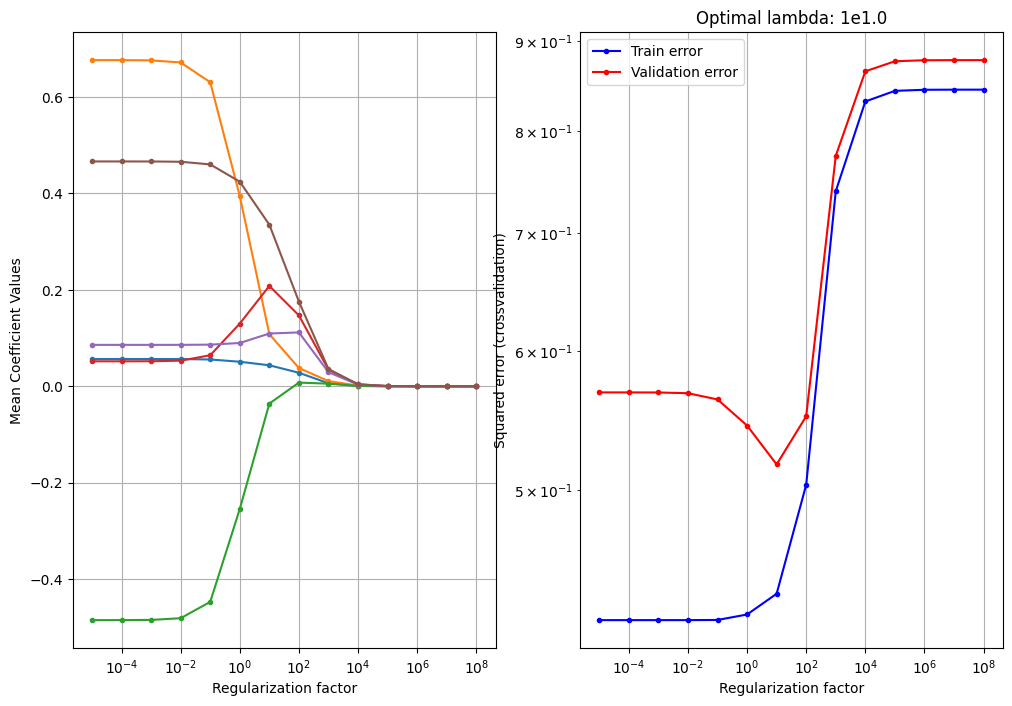

In [97]:
k=0
for train_index, test_index in CV.split(X,y):
    
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10

    opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)
    
    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :] ) / sigma[k, :] 
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :] ) / sigma[k, :] 
    
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train
    
    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0,0] = 0 # Do no regularize the bias term
    w_rlr[:,k] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = np.square(y_train-X_train @ w_rlr[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test_rlr[k] = np.square(y_test-X_test @ w_rlr[:,k]).sum(axis=0)/y_test.shape[0]

    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    model.fit(X_train, y_train)
    Error_train[k] = np.square(y_train-model.predict(X_train)).sum()/y_train.shape[0]
    Error_test[k] = np.square(y_test-model.predict(X_test)).sum()/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K-1:
        figure(k, figsize=(12,8))
        subplot(1,2,1)
        semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'.-') # Don't plot the bias term
        xlabel('Regularization factor')
        ylabel('Mean Coefficient Values')
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner 
        # plot, since there are many attributes
        #legend(attributeNames[1:], loc='best')
        
        subplot(1,2,2)
        title('Optimal lambda: 1e{0}'.format(np.log10(opt_lambda)))
        loglog(lambdas,train_err_vs_lambda.T,'b.-',lambdas,test_err_vs_lambda.T,'r.-')
        xlabel('Regularization factor')
        ylabel('Squared error (crossvalidation)')
        legend(['Train error','Validation error'])
        grid()
    
    # To inspect the used indices, use these print statements
    #print('Cross validation fold {0}/{1}:'.format(k+1,K))
    #print('Train indices: {0}'.format(train_index))
    #print('Test indices: {0}\n'.format(test_index))

    k+=1

   

In [ ]:
print('Linear regression without feature selection:')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Regularized linear regression:')
print('- Training error: {0}'.format(Error_train_rlr.mean()))
print('- Test error:     {0}'.format(Error_test_rlr.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_rlr.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test_rlr.sum())/Error_test_nofeatures.sum()))

print('Weights in last fold:')
for m in range(M):
    print('{:>15} {:>15}'.format(continuous_cols[m], np.round(w_rlr[m,-1],2)))


Linear regression without feature selection:
- Training error: 0.6703944013558611
- Test error:     0.8843749585090823
- R^2 train:     0.32114417196438
- R^2 test:     0.06963921405989136

Regularized linear regression:
- Training error: 0.7255330813015607
- Test error:     0.8848858328455931
- R^2 train:     0.2653095555719625
- R^2 test:     0.06910177522282376

Weights in last fold:
         radius           -0.02
        texture            0.04
      perimeter            0.07
           area            0.05
    compactness             0.1
       symmetry            0.13
fractal_dimension            0.12
